Datasets de empresas e índices cargados correctamente.


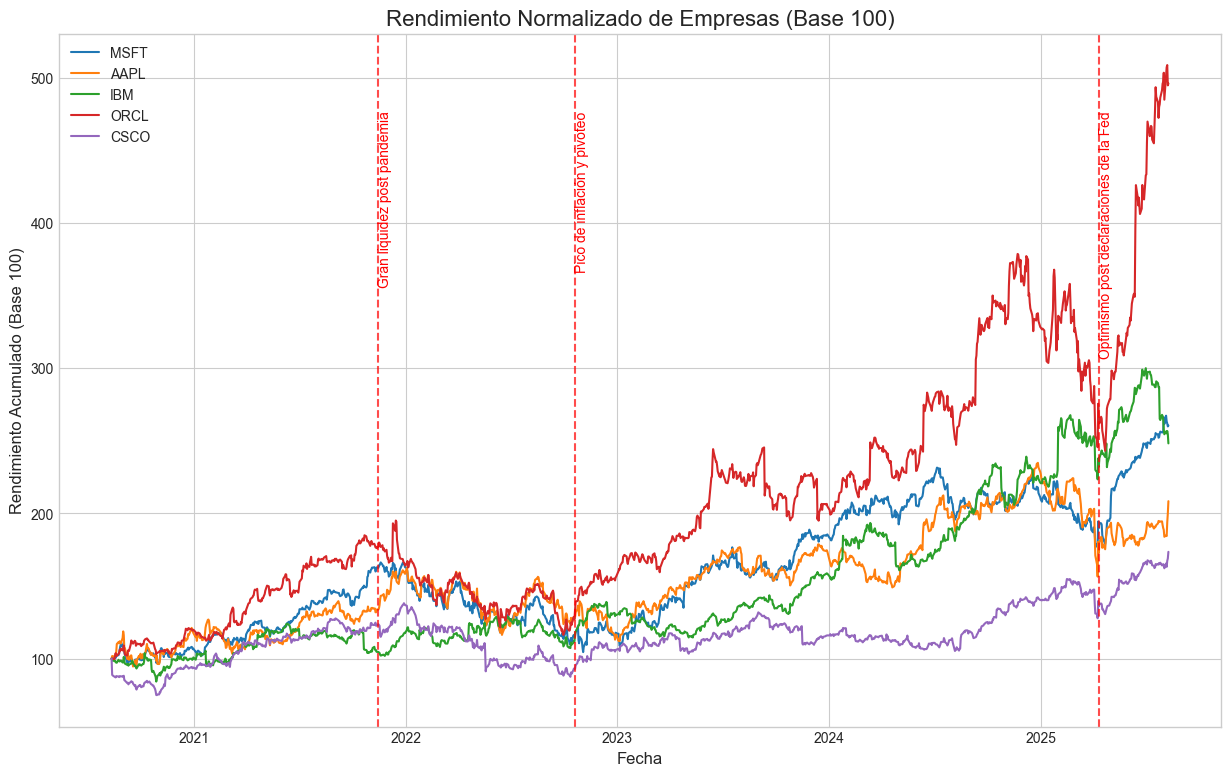

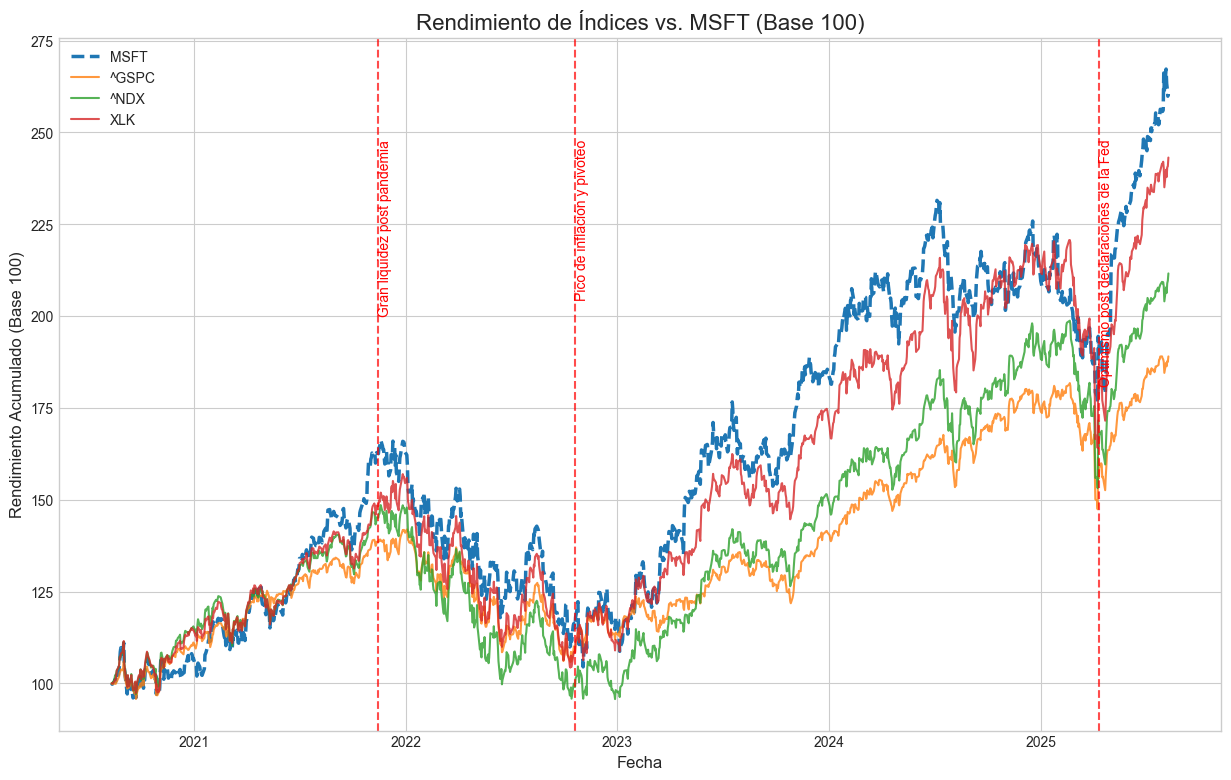

In [19]:
# =================================================================
# Celda 5: Gráficos Normalizados 
# =================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import config as cfg 

# --- Cargar los datasets separados ---
try:
    company_data = pd.read_csv('datos_empresas.csv', index_col='Date', parse_dates=True)
    index_data = pd.read_csv('datos_indices.csv', index_col='Date', parse_dates=True)
    print("Datasets de empresas e índices cargados correctamente.")
except FileNotFoundError:
    print("Error: Asegúrate de que los archivos 'datos_empresas.csv' y 'datos_indices.csv' existen.")

# --- Gráfico 1: Rendimiento Normalizado de Empresas ---
norm_companies = (company_data / company_data.iloc[0]) * 100

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 9))
for column in norm_companies.columns:
    plt.plot(norm_companies.index, norm_companies[column], label=column)

# --- Anotaciones de Eventos Clave ---
events = {
    '2021-11-15': 'Gran liquidez post pandemia',
    '2022-10-20': 'Pico de inflación y pivoteo',
    '2025-04-10': 'Optimismo post declaraciones de la Fed'
}
for date, label in events.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.7)
    plt.text(pd.to_datetime(date), plt.ylim()[1]*0.9, label, rotation=90, verticalalignment='top', color='red', fontsize=10)

plt.title('Rendimiento Normalizado de Empresas (Base 100)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Rendimiento Acumulado (Base 100)', fontsize=12)
plt.legend()
plt.show()

# --- Gráfico 2: Rendimiento Normalizado de Índices vs. Empresa Principal ---
norm_indices = (index_data / index_data.iloc[0]) * 100
norm_empresa_principal = norm_companies[[cfg.EMPRESA_PRINCIPAL]]
plot_data = pd.concat([norm_empresa_principal, norm_indices], axis=1)

plt.figure(figsize=(15, 9))
for column in plot_data.columns:
    if column == cfg.EMPRESA_PRINCIPAL:
        plt.plot(plot_data.index, plot_data[column], label=column, linewidth=2.5, linestyle='--')
    else:
        plt.plot(plot_data.index, plot_data[column], label=column, linewidth=1.5, alpha=0.8)

# --- Anotaciones de Eventos Clave ---
for date, label in events.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.7)
    plt.text(pd.to_datetime(date), plt.ylim()[1]*0.9, label, rotation=90, verticalalignment='top', color='red', fontsize=10)

plt.title(f'Rendimiento de Índices vs. {cfg.EMPRESA_PRINCIPAL} (Base 100)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Rendimiento Acumulado (Base 100)', fontsize=12)
plt.legend()
plt.show()

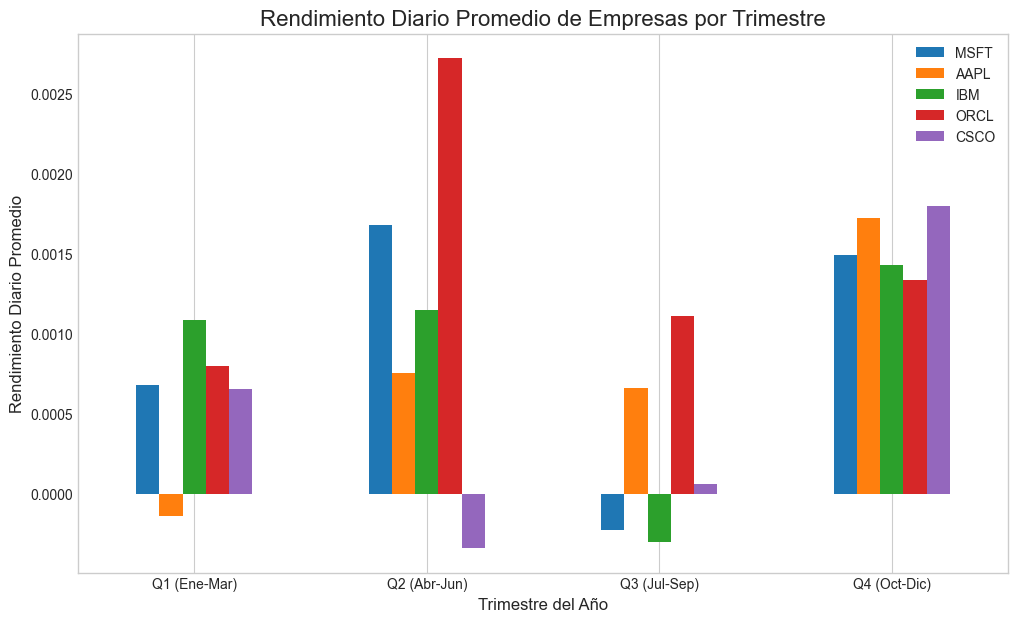

In [3]:
# =================================================================
# Celda 6: Análisis de Estacionalidad por Trimestre
# =================================================================
import pandas as pd
import matplotlib.pyplot as plt

# --- Cargar dataset de empresas ---
try:
    company_data = pd.read_csv('datos_empresas.csv', index_col='Date', parse_dates=True)
except FileNotFoundError:
    print("Error: El archivo 'datos_empresas.csv' no se encontró.")

# Calculamos los retornos diarios solo para las empresas
company_returns = company_data.pct_change().dropna()

# Extraemos el trimestre (1, 2, 3, o 4) del índice de fechas
quarterly_returns = company_returns.groupby(company_returns.index.quarter).mean()

# Graficamos los resultados
quarterly_returns.plot(kind='bar', figsize=(12, 7))
plt.title('Rendimiento Diario Promedio de Empresas por Trimestre', fontsize=16)
plt.xlabel('Trimestre del Año', fontsize=12)
plt.ylabel('Rendimiento Diario Promedio', fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Q1 (Ene-Mar)', 'Q2 (Abr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dic)'], rotation=0)
plt.grid(axis='y')
plt.show()

In [4]:
# =================================================================
# Celda 7: Métricas de Riesgo para Empresas (Modificada)
# =================================================================
import pandas as pd
import numpy as np

# --- Cargar retornos (si no se ha hecho en celdas anteriores) ---
try:
    company_data = pd.read_csv('datos_empresas.csv', index_col='Date', parse_dates=True)
    company_returns = company_data.pct_change().dropna()
except FileNotFoundError:
    print("Error: El archivo 'datos_empresas.csv' no se encontró.")

# --- Función para calcular el Drawdown Máximo ---
def max_drawdown(returns_series):
    wealth_index = (1 + returns_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    return drawdowns.min()

# --- Preparamos la tabla para los resultados ---
risk_metrics = pd.DataFrame(index=company_returns.columns)

# --- Realizamos los cálculos para cada empresa ---
for ticker in company_returns.columns:
    # VaR 95% Histórico
    var_95 = company_returns[ticker].quantile(0.05)
    risk_metrics.loc[ticker, 'VaR 95%'] = var_95
    
    # CVaR 95% Histórico
    cvar_95 = company_returns[ticker][company_returns[ticker] < var_95].mean()
    risk_metrics.loc[ticker, 'CVaR 95%'] = cvar_95
    
    # Drawdown Máximo
    max_dd = max_drawdown(company_returns[ticker])
    risk_metrics.loc[ticker, 'Max Drawdown'] = max_dd

# --- Formateamos los resultados ---
risk_metrics['VaR 95%'] = risk_metrics['VaR 95%'].apply(lambda x: f'{x:.2%}')
risk_metrics['CVaR 95%'] = risk_metrics['CVaR 95%'].apply(lambda x: f'{x:.2%}')
risk_metrics['Max Drawdown'] = risk_metrics['Max Drawdown'].apply(lambda x: f'{x:.2%}')

print("Tabla de Métricas de Riesgo para las Empresas")
display(risk_metrics)

Tabla de Métricas de Riesgo para las Empresas


,VaR 95%,CVaR 95%,Max Drawdown
MSFT,-2.68%,-3.71%,-37.15%
AAPL,-2.98%,-4.12%,-33.36%
IBM,-1.97%,-3.40%,-18.89%
ORCL,-2.74%,-4.44%,-40.36%
CSCO,-2.01%,-3.33%,-36.68%


Test de Normalidad de Retornos (Jarque-Bera)


,Jarque-Bera Stat,P-Value
MSFT,453.255705,3.773759e-99
AAPL,1613.644755,0.000000e+00
IBM,6546.657216,0.000000e+00
ORCL,7167.600615,0.000000e+00
CSCO,9476.079504,0.000000e+00


Un P-Value cercano a 0 indica que los retornos NO siguen una distribución normal.


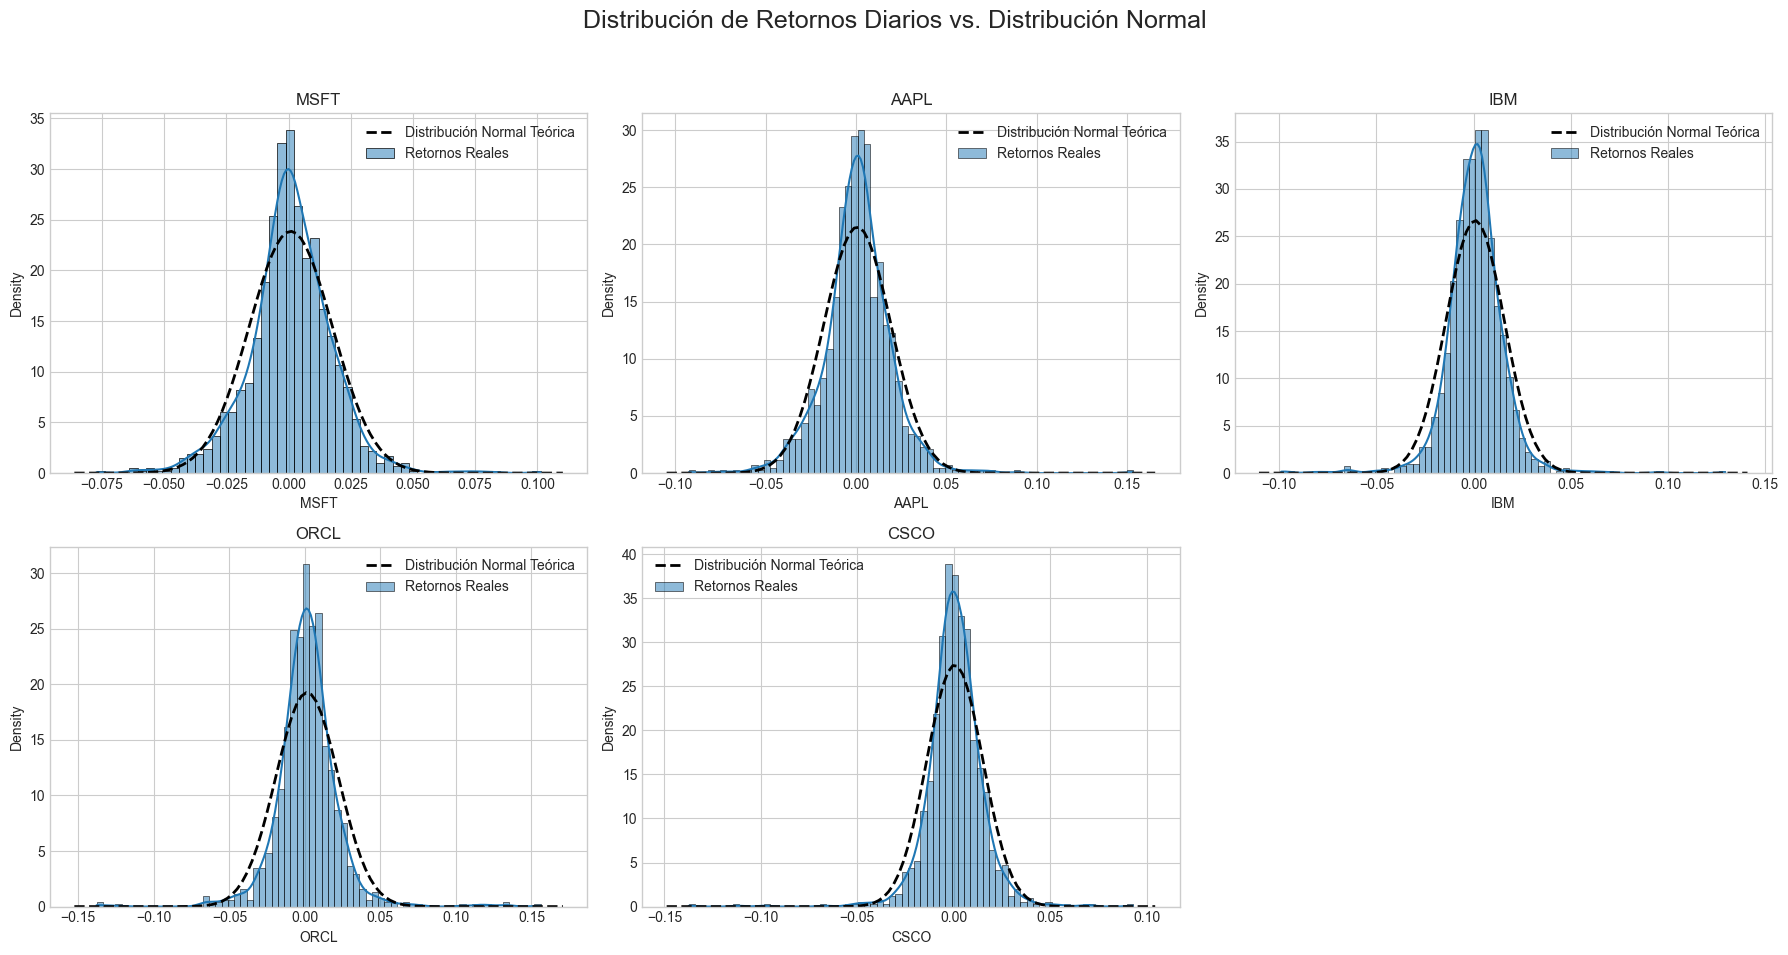

In [5]:
# =================================================================
# Celda 8: Análisis de Normalidad y Gráficos de Distribución
# =================================================================
from scipy.stats import jarque_bera, norm
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Test de Normalidad (Jarque-Bera) ---
normality_test = pd.DataFrame(index=company_returns.columns)
for ticker in company_returns.columns:
    jb_stat, jb_pvalue = jarque_bera(company_returns[ticker])
    normality_test.loc[ticker, 'Jarque-Bera Stat'] = jb_stat
    normality_test.loc[ticker, 'P-Value'] = jb_pvalue

print("Test de Normalidad de Retornos (Jarque-Bera)")
display(normality_test)
print("Un P-Value cercano a 0 indica que los retornos NO siguen una distribución normal.")


# --- 2. Gráficos de Distribución de Retornos ---
# Creamos una figura con una cuadrícula de subplots para organizar los gráficos
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribución de Retornos Diarios vs. Distribución Normal', fontsize=18)
axes = axes.flatten() # Convertimos la matriz de ejes en un array plano para iterar fácilmente

for i, ticker in enumerate(company_returns.columns):
    ax = axes[i]
    # Graficamos el histograma y la densidad de los retornos reales
    sns.histplot(company_returns[ticker], ax=ax, kde=True, stat='density', label='Retornos Reales')
    
    # Superponemos la distribución normal teórica con la misma media y desviación estándar
    mu, std = norm.fit(company_returns[ticker])
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k--', linewidth=2, label='Distribución Normal Teórica')
    
    ax.set_title(ticker)
    ax.legend()

# Ocultamos los ejes de los subplots que no se usan (si hay)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustamos el layout para que el título no se superponga
plt.show()

Company returns are loaded and ready.


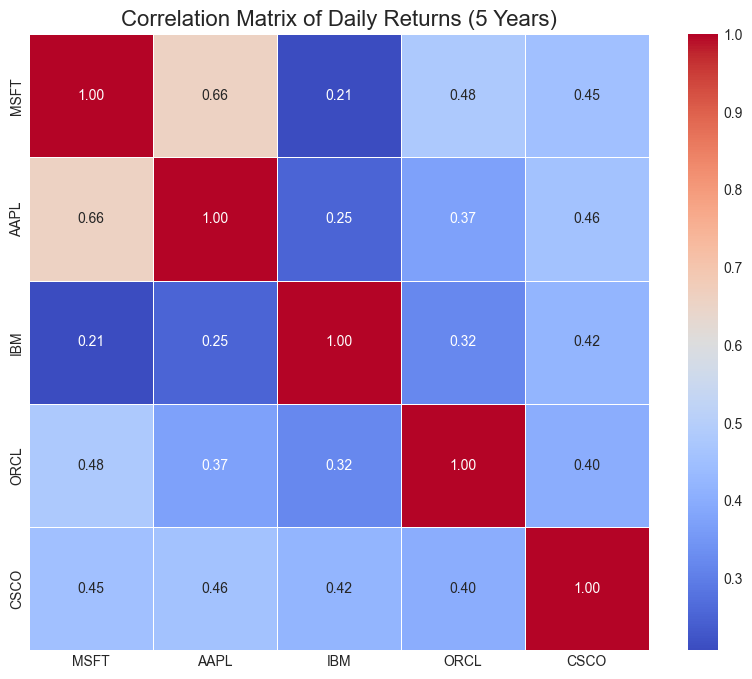


Correlation Matrix:


,MSFT,AAPL,IBM,ORCL,CSCO
MSFT,1.000000,0.657188,0.207676,0.479424,0.451145
AAPL,0.657188,1.000000,0.251306,0.374584,0.457790
IBM,0.207676,0.251306,1.000000,0.321509,0.419633
ORCL,0.479424,0.374584,0.321509,1.000000,0.402542
CSCO,0.451145,0.457790,0.419633,0.402542,1.000000


In [6]:
# =================================================================
# Celda 9: Matriz de Correlaciones
# =================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the company returns we've used before
try:
    company_data = pd.read_csv('datos_empresas.csv', index_col='Date', parse_dates=True)
    company_returns = company_data.pct_change().dropna()
    print("Company returns are loaded and ready.")
except FileNotFoundError:
    print("Error: 'datos_empresas.csv' not found. Please run the previous cells first.")

# Calculate the correlation matrix
correlation_matrix = company_returns.corr()

# Create the heatmap to visualize the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Daily Returns (5 Years)', fontsize=16)
plt.show()

# Display the data table
print("\nCorrelation Matrix:")
display(correlation_matrix)

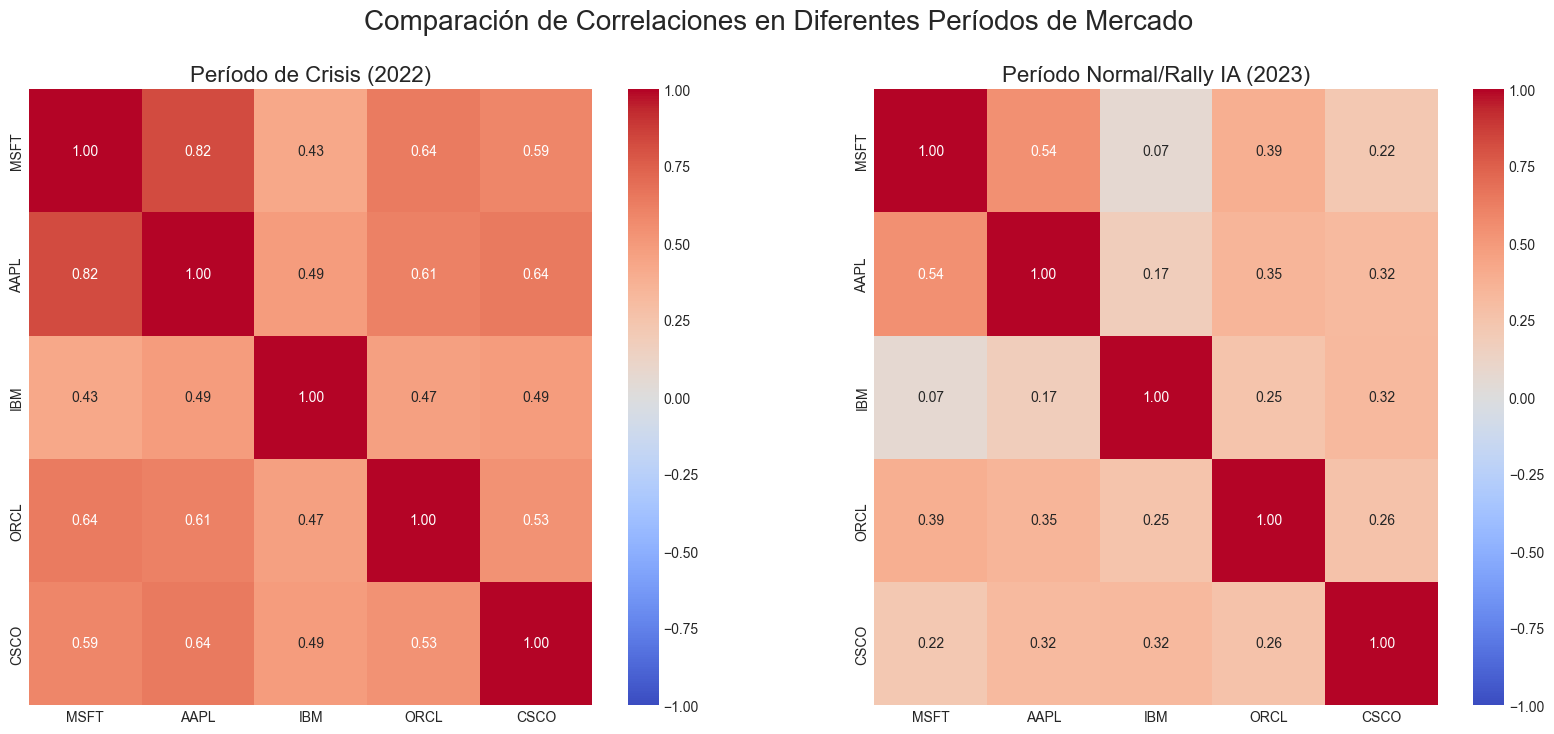

In [7]:
# =================================================================
# Celda 10: Correlaciones con Escala de Color Fija
# =================================================================

# Definimos los períodos de tiempo
crisis_start = '2022-01-01'
crisis_end = '2022-12-31'
normal_start = '2023-01-01'
normal_end = '2023-12-31'

# Filtramos los retornos para cada período
crisis_returns = company_returns.loc[crisis_start:crisis_end]
normal_returns = company_returns.loc[normal_start:normal_end]

# Calculamos las matrices de correlación para cada período
crisis_corr = crisis_returns.corr()
normal_corr = normal_returns.corr()

# Creamos dos gráficos lado a lado para comparar
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparación de Correlaciones en Diferentes Períodos de Mercado', fontsize=20)

# --- Gráfico de período de crisis ---
# Añadimos vmin=-1 y vmax=1 para fijar la escala de color
sns.heatmap(crisis_corr, ax=axes[0], annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
axes[0].set_title('Período de Crisis (2022)', fontsize=16)

# --- Gráfico de período normal ---
# Usamos los mismos vmin y vmax para que la comparación sea directa
sns.heatmap(normal_corr, ax=axes[1], annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
axes[1].set_title('Período Normal/Rally IA (2023)', fontsize=16)

plt.show()

In [8]:
# =================================================================
# Celda 11: Setup para la Optimización
# =================================================================
import pandas as pd
import numpy as np

# Cargamos los retornos de las empresas
try:
    company_data = pd.read_csv('datos_empresas.csv', index_col='Date', parse_dates=True)
    returns = company_data.pct_change().dropna()
    print("Retornos de empresas cargados.")
except FileNotFoundError:
    print("Error: No se encontró el archivo 'datos_empresas.csv'.")

# --- Cálculo de Insumos Anualizados ---
# Asumimos 252 días de trading en un año
annual_returns = returns.mean() * 252
annual_cov_matrix = returns.cov() * 252

# --- Tasa Libre de Riesgo (Risk-Free Rate) ---
# Usamos un valor aproximado para el rendimiento de un Bono del Tesoro de EE.UU.
risk_free_rate = 0.04 # 4% anual

print("\nRetorno Anualizado Esperado de cada activo:")
print(annual_returns)

Retornos de empresas cargados.

Retorno Anualizado Esperado de cada activo:
MSFT    0.227798
AAPL    0.190826
IBM     0.211106
ORCL    0.376033
CSCO    0.137797
dtype: float64


In [9]:
# =================================================================
# Celda 12: Simulación de Monte Carlo
# =================================================================

num_portfolios = 20000
num_assets = len(returns.columns)
results = []
transaction_cost = 0.005 # 0.5%

for i in range(num_portfolios):
    # Generamos ponderaciones aleatorias que cumplen las restricciones
    # Este método asegura que todas las ponderaciones estén entre 5% y 40%
    weights = np.random.random(num_assets)
    weights /= np.sum(weights) # Normalizamos para que sumen 1
    
    # Nos aseguramos que las restricciones se cumplan, si no, se re-ajustan
    while any(w > 0.40 for w in weights) or any(w < 0.05 for w in weights):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)

    # Cálculo de métricas del portfolio
    portfolio_return = np.sum(weights * annual_returns) - transaction_cost
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(annual_cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    # Guardamos los resultados
    results.append([portfolio_return, portfolio_volatility, sharpe_ratio] + list(weights))

# Convertimos la lista de resultados en un DataFrame
results_df = pd.DataFrame(results, columns=['retorno', 'volatilidad', 'sharpe_ratio'] + list(returns.columns))

print(f"{len(results_df)} porfolios aleatorios simulados exitosamente.")
print("\nPrimeras 5 filas de los resultados de la simulación:")
display(results_df.head())

20000 porfolios aleatorios simulados exitosamente.

Primeras 5 filas de los resultados de la simulación:


,retorno,volatilidad,sharpe_ratio,MSFT,AAPL,IBM,ORCL,CSCO
0,0.228742,0.195138,0.967221,0.126234,0.196942,0.275445,0.226445,0.174933
1,0.242264,0.210912,0.958997,0.183299,0.221988,0.113920,0.305774,0.175019
2,0.194328,0.191351,0.806518,0.192588,0.237074,0.231227,0.061598,0.277513
3,0.199070,0.209823,0.758116,0.118618,0.363671,0.054225,0.135735,0.327751
4,0.224815,0.215830,0.856301,0.150479,0.357977,0.056930,0.232200,0.202413


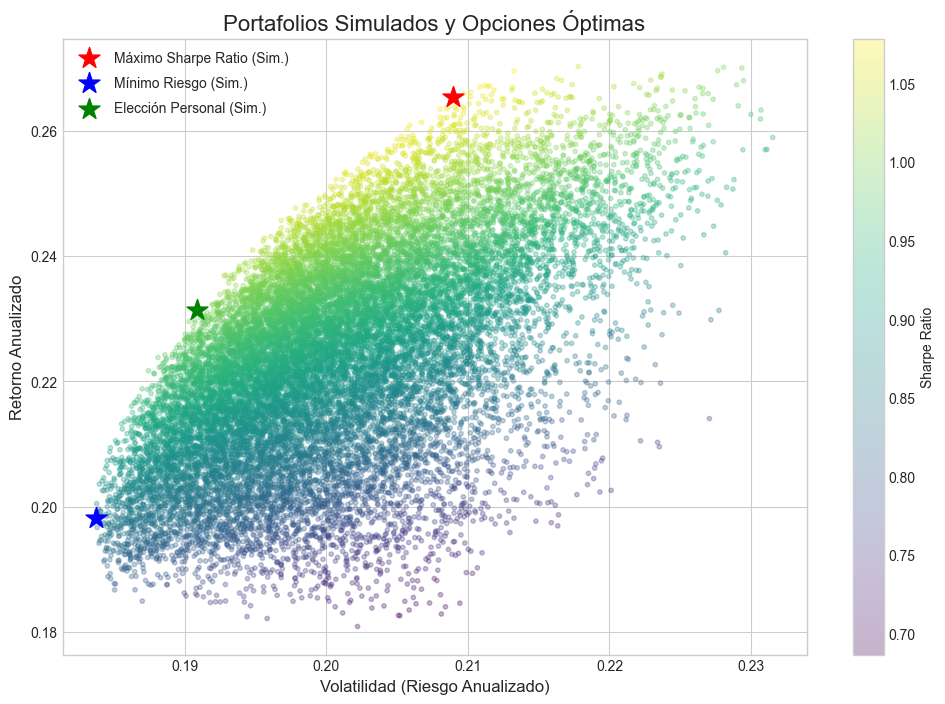

In [10]:
# =================================================================
# Celda 13: Gráfico Final de Portafolios Simulados
# =================================================================
import matplotlib.pyplot as plt
import pandas as pd

# 1. IDENTIFICAR LOS PORTAFOLIOS CLAVE DE LA SIMULACIÓN
max_sharpe_portfolio = results_df.loc[results_df['sharpe_ratio'].idxmax()]
min_vol_portfolio = results_df.loc[results_df['volatilidad'].idxmin()]

preferred_vol_subset = results_df[(results_df['volatilidad'] >= 0.189) & (results_df['volatilidad'] <= 0.191)]
if preferred_vol_subset.empty:
    print("Advertencia: No se encontró ningún portafolio con ~19% de volatilidad. Usando el de mínimo riesgo como sustituto.")
    personal_choice_portfolio = min_vol_portfolio
else:
    personal_choice_portfolio = preferred_vol_subset.loc[preferred_vol_subset['retorno'].idxmax()]

# 2. GENERAR EL GRÁFICO
plt.figure(figsize=(12, 8))

# Nube de puntos de todos los portafolios simulados
plt.scatter(results_df['volatilidad'], results_df['retorno'], c=results_df['sharpe_ratio'], cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')

# Títulos y etiquetas
plt.xlabel('Volatilidad (Riesgo Anualizado)', fontsize=12)
plt.ylabel('Retorno Anualizado', fontsize=12)
plt.title('Portafolios Simulados y Opciones Óptimas', fontsize=16)

# Marcamos los 3 portafolios de interés con estrellas
plt.scatter(max_sharpe_portfolio['volatilidad'], max_sharpe_portfolio['retorno'], marker='*', color='r', s=250, label='Máximo Sharpe Ratio (Sim.)')
plt.scatter(min_vol_portfolio['volatilidad'], min_vol_portfolio['retorno'], marker='*', color='b', s=250, label='Mínimo Riesgo (Sim.)')
plt.scatter(personal_choice_portfolio['volatilidad'], personal_choice_portfolio['retorno'], marker='*', color='g', s=250, label='Elección Personal (Sim.)')

# Leyenda y grilla
plt.legend(labelspacing=0.8)
plt.grid(True)
plt.show()

In [ ]:
# =================================================================
# Celda 14: Composición de los Portafolios
# =================================================================

# --- Función para mostrar los resultados de forma prolija ---
def display_sim_portfolio(portfolio_series, title, subtitle):
    """Toma una serie de portafolio y muestra sus detalles de forma ordenada."""
    
    # --- CORRECCIÓN AQUÍ ---
    # En lugar de tomar "las últimas columnas", seleccionamos explícitamente
    # las columnas que coinciden con los tickers de las empresas.
    # Esto evita incluir columnas no deseadas como 'vol_bin'.
    weights = portfolio_series[returns.columns]
    
    composition = pd.DataFrame(weights)
    composition.columns = ['Ponderación']
    composition['Ponderación'] = composition['Ponderación'].apply(lambda x: f'{x:.2%}')
    
    print(f"--- {title} ---")
    print(subtitle)
    print(f"Retorno Anualizado: {portfolio_series['retorno']:.2%}")
    print(f"Volatilidad Anualizada: {portfolio_series['volatilidad']:.2%}")
    print(f"Sharpe Ratio: {portfolio_series['sharpe_ratio']:.2f}")
    display(composition)

# --- Mostramos cada portafolio seleccionado de la simulación ---
display_sim_portfolio(max_sharpe_portfolio, 
                      "Portafolio de Máximo Sharpe Ratio (Simulación)",
                      "Este portafolio de la simulación ofrece el mejor retorno por unidad de riesgo.")

print("\n")
display_sim_portfolio(min_vol_portfolio,
                      "Portafolio de Mínimo Riesgo (Simulación)",
                      "Este es el portafolio menos volátil encontrado en la simulación.")

print("\n")
display_sim_portfolio(personal_choice_portfolio,
                      "Elección Personal (Simulación)",
                      "Este portafolio de la simulación maximiza el retorno para una volatilidad de ~19%.")

--- Portafolio de Máximo Sharpe Ratio (Simulación) ---
Este portafolio de la simulación ofrece el mejor retorno por unidad de riesgo.
Retorno Anualizado: 26.54%
Volatilidad Anualizada: 20.89%
Sharpe Ratio: 1.08


,Ponderación
MSFT,14.11%
AAPL,5.26%
IBM,37.97%
ORCL,37.46%
CSCO,5.19%




--- Portafolio de Mínimo Riesgo (Simulación) ---
Este es el portafolio menos volátil encontrado en la simulación.
Retorno Anualizado: 19.82%
Volatilidad Anualizada: 18.37%
Sharpe Ratio: 0.86


,Ponderación
MSFT,24.81%
AAPL,7.50%
IBM,36.96%
ORCL,5.03%
CSCO,25.69%




--- Elección Personal (Simulación) ---
Este portafolio de la simulación maximiza el retorno para una volatilidad de ~19%.
Retorno Anualizado: 23.14%
Volatilidad Anualizada: 19.09%
Sharpe Ratio: 1.00


,Ponderación
MSFT,21.28%
AAPL,7.75%
IBM,38.11%
ORCL,19.91%
CSCO,12.94%
